# Torch

In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# use GPU if available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  #'cpu' # 'cuda' or 'cpu'

print(DEVICE)

cuda:0


# Download Dataset GTEA61
For Google Colab

In [2]:
""" 

from google.colab import drive
import os
drive.mount('/content/drive')
import sys, os

if not os.path.isfile('/content/GTEA61'):

  !unzip  "/content/drive/MyDrive/Colab Notebooks/GTEA61.zip" -d "/content/"

if not os.path.isdir('/content/GTEA61'):
  print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/best_model_state_dict_rgb_split2.pth"):
  !gdown --id 1B7Xh6hQ9Py8fmL-pjmLzlCent6dnuex5 # 3-5 min

  
# original

import os

#1YKfdhB9Xxh4pmND1V3gcm3Gyjc8v8idq
if not os.path.isfile('/content/GTEA61.zip'):
  !gdown --id 1Z5RWA8yKIy0PvxMlScV-aAz22ITtivfk # 3-5 min
  !jar xvf  "/content/GTEA61.zip"

if not os.path.isdir('/content/GTEA61'):
  print("Dataset doesn't exist")

#Weights
if not os.path.isfile("best_model_state_dict_rgb_split2.pth"):
  !gdown --id 1B7Xh6hQ9Py8fmL-pjmLzlCent6dnuex5

"""

' \n\nfrom google.colab import drive\nimport os\ndrive.mount(\'/content/drive\')\nimport sys, os\n\nif not os.path.isfile(\'/content/GTEA61\'):\n  !unzip  "/content/drive/MyDrive/Colab Notebooks/GTEA61.zip" -d "/content/"\n\nif not os.path.isdir(\'/content/GTEA61\'):\n  print("Dataset doesn\'t exist")\n\n#Weights\nif not os.path.isfile("/content/best_model_state_dict_rgb_split2.pth"):\n  !gdown --id 1B7Xh6hQ9Py8fmL-pjmLzlCent6dnuex5 # 3-5 min\n\n'


# Download Code

In [3]:
import os 

if not os.path.isdir('Homework_AIML'):
    !git clone "https://github.com/plana93/Homework_AIML.git"



# Import Code


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.backends import cudnn
from colorama import init
from colorama import Fore, Back, Style

from torchvision.models import resnet34
from PIL import Image
from tqdm import tqdm

import sys
import os

sys.path.append("Homework_AIML/")
import Homework_AIML
from Homework_AIML import *

from gtea_dataset import GTEA61, GTEA61_flow, GTEA61_2Stream
from spatial_transforms import (
    Compose,
    ToTensor,
    CenterCrop,
    Scale,
    Normalize,
    MultiScaleCornerCrop,
    RandomHorizontalFlip,
)

# **Learning without Temporal information** (avgpool)

## MAIN PARAMs

In [3]:
homework_step = 0  # --> Learning without Temporal information (avgpool)
# homework_step = 1 #--> Learning with Temporal information (LSTM)
# homework_step = 2 #--> Learning with Spatio-Temporal information (ConvLSTM)


DATA_DIR = "datasets/GTEA61/"  # path dataset
model_folder = "saved_models/" + "homework_step" + str(homework_step) + "/"  # path to save model
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)


# All this param can be change!

NUM_CLASSES = 61
BATCH_SIZE = 64
LR = 0.001  # The initial Learning Rate
MOMENTUM = 0.9  # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 4e-5  # Regularization, you can keep this at the default
NUM_EPOCHS = 100  # Total number of training epochs (iterations over dataset)
STEP_SIZE = [20, 50, 75]  # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1  # Multiplicative factor for learning rate step-down
MEM_SIZE = 512  # Dim of internal state of LSTM or ConvLSTM
SEQ_LEN = 5  # Num Frames

# this dictionary is needed for the logger class
parameters = {
    "DEVICE": DEVICE,
    "NUM_CLASSES": NUM_CLASSES,
    "BATCH_SIZE": BATCH_SIZE,
    "LR": LR,
    "MOMENTUM": MOMENTUM,
    "WEIGHT_DECAY": WEIGHT_DECAY,
    "NUM_EPOCHS": NUM_EPOCHS,
    "STEP_SIZE": STEP_SIZE,
    "GAMMA": GAMMA,
    "MEM_SIZE": MEM_SIZE,
    "SEQ_LEN": SEQ_LEN,
}

## Dataloaders & Preprocessing

In [4]:
# Normalize
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


normalize = Normalize(mean=mean, std=std)


spatial_transform = Compose(
    [Scale(256), RandomHorizontalFlip(), MultiScaleCornerCrop([1, 0.875, 0.75, 0.65625], 224), ToTensor(), normalize]
)


spatial_transform_val = Compose([Scale(256), CenterCrop(224), ToTensor(), normalize])

In [5]:
# Prepare Pytorch train/test Datasets
train_dataset = GTEA61(DATA_DIR, split="train", transform=spatial_transform, seq_len=SEQ_LEN)
test_dataset = GTEA61(DATA_DIR, split="test", transform=spatial_transform_val, seq_len=SEQ_LEN)

# Check dataset sizes
print("Train Dataset: {}".format(len(train_dataset)))
print("Test Dataset: {}".format(len(test_dataset)))

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

['S1', 'S2', 'S3', 'S4']
['S1', 'S2', 'S3', 'S4']
Train Dataset: 341
Test Dataset: 116


In [6]:
def plot_cam(img, cam_img):
    plt.figure()
    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')

    # axes are in a two-dimensional array, indexed by [row, col]
    ax[0].title.set_text('Original Image')
    ax[1].title.set_text('Cam Image')

    ax[0].imshow(img)
    ax[1].imshow(cam_img)
    plt.show()

## Model

In [10]:
import torch
import resnetMod
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable


# LSTM
class MyLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLSTMCell, self).__init__()

        self.linear_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.linear_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.linear_g = nn.Linear(input_size + hidden_size, hidden_size)
        self.linear_o = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, state):
        if state is None:
            state = (
                Variable(torch.randn(x.size(0), x.size(1)).cuda()),
                Variable(torch.randn(x.size(0), x.size(1)).cuda()),
            )

        c_t1, h_t1 = state
        input = torch.hstack((h_t1, x))
        f = torch.sigmoid(self.linear_f(input))
        i = torch.sigmoid(self.linear_i(input))
        g = torch.tanh(self.linear_g(input))
        o = torch.sigmoid(self.linear_o(input))

        c_t = f * c_t1 + (i * g)
        h_t = o * torch.tanh(c_t)

        return c_t, h_t


# ConvLSTM
class MyConvLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size=3, stride=1, padding=1):
        super(MyConvLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.conv_i_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_i_hh = nn.Conv2d(
            hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding, bias=False
        )

        self.conv_f_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_f_hh = nn.Conv2d(
            hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding, bias=False
        )

        self.conv_c_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_c_hh = nn.Conv2d(
            hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding, bias=False
        )

        self.conv_o_xx = nn.Conv2d(input_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv_o_hh = nn.Conv2d(
            hidden_size, hidden_size, kernel_size=kernel_size, stride=stride, padding=padding, bias=False
        )

        torch.nn.init.xavier_normal_(self.conv_i_xx.weight)
        torch.nn.init.constant_(self.conv_i_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_i_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_f_xx.weight)
        torch.nn.init.constant_(self.conv_f_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_f_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_c_xx.weight)
        torch.nn.init.constant_(self.conv_c_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_c_hh.weight)

        torch.nn.init.xavier_normal_(self.conv_o_xx.weight)
        torch.nn.init.constant_(self.conv_o_xx.bias, 0)
        torch.nn.init.xavier_normal_(self.conv_o_hh.weight)

    def forward(self, x, state):
        if state is None:
            state = (
                Variable(torch.randn(x.size(0), x.size(1), x.size(2), x.size(3)).cuda()),
                Variable(torch.randn(x.size(0), x.size(1), x.size(2), x.size(3)).cuda()),
            )

        c_t1, h_t1 = state

        f = torch.sigmoid(self.conv_f_xx(x) + self.conv_f_hh(h_t1))
        i = torch.sigmoid(self.conv_i_xx(x) + self.conv_i_hh(h_t1))
        g = torch.tanh(self.conv_c_xx(x) + self.conv_c_hh(h_t1))
        o = torch.sigmoid(self.conv_o_xx(x) + self.conv_o_hh(h_t1))

        c_t = f * c_t1 + (i * g)
        h_t = o * torch.tanh(c_t)

        return c_t, h_t


# Network
class ourModel(nn.Module):
    def __init__(self, num_classes=61, mem_size=512, homework_step=0, DEVICE=""):
        super(ourModel, self).__init__()
        self.DEVICE = DEVICE
        self.num_classes = num_classes
        self.resNet = resnetMod.resnet34(True, True)
        self.mem_size = mem_size
        self.weight_softmax = self.resNet.fc.weight
        self.homework_step = homework_step
        if self.homework_step == 1:
            self.lstm_cell = MyLSTMCell(512, mem_size)
        elif self.homework_step == 2:
            self.lstm_cell = MyConvLSTMCell(512, mem_size)

        self.avgpool = nn.AvgPool2d(7)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(mem_size, self.num_classes)
        self.classifier = nn.Sequential(self.dropout, self.fc)

    def forward(self, inputVariable):
        # Learning without Temporal information (mean)
        if self.homework_step == 0:
            video_level_features = torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE)
            for t in range(inputVariable.size(0)):
                # spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                # frames_feat: (bs, 512)
                frame_feat = self.avgpool(spatial_frame_feat).view(spatial_frame_feat.size(0), -1)
                video_level_features = video_level_features + frame_feat

            video_level_features = video_level_features / inputVariable.size(0)
            logits = self.classifier(video_level_features)
            return logits, video_level_features

        # Learning with Temporal information (LSTM)
        elif self.homework_step == 1:
            # inputVariable = (Frames, BS, C, W, H)
            state = (
                torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE),  # h_t
                torch.zeros((inputVariable.size(1), self.mem_size)).to(self.DEVICE),  # c_t
            )
            # for each frame (t -> tempo)
            for t in range(inputVariable.size(0)):
                # spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                # frames_feat: (bs, 512)
                frame_feat = self.avgpool(spatial_frame_feat).view(state[1].size(0), -1)
                # in this way the state t go in the cell at t + 1
                state = self.lstm_cell(frame_feat, state)

            video_level_features = state[1]
            logits = self.classifier(video_level_features)
            return logits, video_level_features

        # Learning with Temporal information (ConvLSTM)
        elif self.homework_step == 2:
            state = (
                torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).to(self.DEVICE),
                torch.zeros((inputVariable.size(1), self.mem_size, 7, 7)).to(self.DEVICE),
            )
            for t in range(inputVariable.size(0)):
                # spatial_frame_feat: (bs, 512, 7, 7)
                _, spatial_frame_feat, _ = self.resNet(inputVariable[t])
                state = self.lstm_cell(spatial_frame_feat, state)
            video_level_features = self.avgpool(state[1]).view(state[1].size(0), -1)
            logits = self.classifier(video_level_features)
            return logits, video_level_features

    def class_activation_map(self, inputVariable, mean, std):
        # for each temporal information (given by SEQ_LEN )
        for t in range(inputVariable.size(0)):
            # get the logit exit (bs,num_class) and feature conv (bs,512,7,7) of resnet
            logit, feature_conv, _ = self.resNet(inputVariable[t])
            bz, nc, h, w = feature_conv.size()
            # (bs,512,49)
            feature_conv1 = feature_conv.view(bz, nc, h * w)
            # sort the logit exit, in the way to have in the first column the class predicted in idxs
            probs, idxs = logit.sort(1, True)
            # get the class for each image in the batch size
            class_idx = idxs[:, 0]
            # product between features and the weights for the classes
            cam = torch.bmm(self.weight_softmax[class_idx].unsqueeze(1), feature_conv1)

            for i, cam_img in enumerate(cam):
                # restore the original image
                img = inputVariable[t][i].cpu().permute(1, 2, 0).numpy()
                # apply the inverse of the preprocessing
                img = np.uint8(255 * np.clip(std * img + mean, 0, 1))

                # softmax in the cam image
                cam_img = F.softmax(cam_img, 1).data
                cam_img = cam_img.cpu().numpy()

                cam_img = cam_img.reshape(h, w)
                # minMax scaler, scale the image between [0,1]
                cam_img = cam_img - np.min(cam_img)
                cam_img = cam_img / np.max(cam_img)
                # scale to 255
                cam_img = np.uint8(255 * cam_img)
                output_cam = cv2.resize(cam_img, (224, 224))

                # pass from green to 3 color to view the differences
                heatmap = cv2.applyColorMap(output_cam, cv2.COLORMAP_JET)
                result = np.uint8(heatmap * 0.3 + img * 0.5)

                result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)

                plot_cam(img, result)
                key = input('Press any for next image, press q to quit:')
                if key == 'q':
                    return

## Build Model - Loss - Opt

In [11]:
# CUDA_LAUNCH_BLOCKING=1
validate = True

model = ourModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE, homework_step=homework_step, DEVICE=DEVICE)  # model

# Train only the lstm cell and classifier
model.train(False)
for params in model.parameters():
    params.requires_grad = False

if homework_step > 0:
    for params in model.lstm_cell.parameters():
        params.requires_grad = True
    model.lstm_cell.train(True)

for params in model.classifier.parameters():
    params.requires_grad = True
model.classifier.train(True)


# model = model.to(DEVICE)

model.load_state_dict(torch.load(model_folder + 'model', map_location=torch.device('cpu')), strict=True)

# Loss
loss_fn = nn.CrossEntropyLoss()
# Opt
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
# Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

## Training


In [10]:
def training(model, homework_step=0, model_checkpoint="model", patience=10, save_model=False):
    patience_count = 0
    train_iter = 0
    val_iter = 0
    min_accuracy = 0

    trainSamples = len(train_dataset) - (len(train_dataset) % BATCH_SIZE)
    val_samples = len(test_dataset)

    iterPerEpoch = len(train_loader)
    val_steps = len(val_loader)

    cudnn.benchmark

    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0
        numCorrTrain = 0

        # blocks to train
        if homework_step > 0:
            model.lstm_cell.train(True)

        model.classifier.train(True)

        for i, (inputs, targets) in enumerate(train_loader):
            train_iter += 1
            optimizer_fn.zero_grad()

            # (BS, Frames, C, W, H) --> (Frames, BS, C, W, H)

            inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
            labelVariable = targets.to(DEVICE)

            # feeds in model
            output_label, _ = model(inputVariable)

            # compute loss
            loss = loss_fn(output_label, labelVariable)

            # backward loss and optimizer step
            loss.backward()
            optimizer_fn.step()

            # compute the training accuracy
            _, predicted = torch.max(output_label.data, 1)
            numCorrTrain += torch.sum(predicted == labelVariable.data).data.item()
            step_loss = loss.data.item()

            epoch_loss += step_loss

        avg_loss = epoch_loss / iterPerEpoch

        trainAccuracy = (numCorrTrain / trainSamples) * 100
        # train_logger.add_epoch_data(epoch+1, trainAccuracy, avg_loss)

        print(Fore.WHITE + f"Train: Epoch = {epoch + 1} | Loss = {avg_loss:.3f} | Accuracy = {trainAccuracy:.3f}")
        if validate:
            if (epoch + 1) % 1 == 0:
                model.train(False)
                val_loss_epoch = 0
                numCorr = 0
                for j, (inputs, targets) in enumerate(val_loader):
                    val_iter += 1

                    inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
                    labelVariable = targets.to(DEVICE)

                    output_label, _ = model(inputVariable)
                    val_loss = loss_fn(output_label, labelVariable)
                    val_loss_step = val_loss.data.item()

                    val_loss_epoch += val_loss_step
                    _, predicted = torch.max(output_label.data, 1)
                    numCorr += torch.sum(predicted == labelVariable.data).data.item()

                    # val_logger.add_step_data(val_iter, numCorr, val_loss_step)

                val_accuracy = (numCorr / val_samples) * 100
                avg_val_loss = val_loss_epoch / val_steps

                print(
                    Fore.GREEN
                    + "Val: Epoch = {} | Loss {:.3f} | Accuracy = {:.3f}".format(epoch + 1, avg_val_loss, val_accuracy)
                )
                if val_accuracy > min_accuracy:
                    print("[||| NEW BEST on val||||]")
                    patience_count = 0
                    if save_model:
                        save_path_model = os.path.join(model_folder, model_checkpoint)
                        torch.save(model.state_dict(), save_path_model)
                    min_accuracy = val_accuracy
                elif val_accuracy < min_accuracy:
                    patience_count += 1

            if patience_count == patience:
                print(Fore.RED + "EARLY STOPPING")
                break

        optim_scheduler.step()

    print(Fore.CYAN + "Best Acc --> ", min_accuracy)
    print(Fore.CYAN + "Last Acc --> ", val_accuracy)

    return model

In [12]:
training(model, homework_step=0, patience=5)

Train: Epoch = 1 | Loss = 4.630 | Accuracy = 4.688
Val: Epoch = 1 | Loss 4.037 | Accuracy = 9.483
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 4.413 | Accuracy = 5.312
Val: Epoch = 2 | Loss 4.004 | Accuracy = 5.172
Train: Epoch = 3 | Loss = 4.469 | Accuracy = 3.438
Val: Epoch = 3 | Loss 3.952 | Accuracy = 5.172
Train: Epoch = 4 | Loss = 4.313 | Accuracy = 5.625
Val: Epoch = 4 | Loss 3.877 | Accuracy = 6.034
Train: Epoch = 5 | Loss = 4.344 | Accuracy = 3.125
Val: Epoch = 5 | Loss 3.813 | Accuracy = 8.621
Train: Epoch = 6 | Loss = 4.219 | Accuracy = 4.062
Val: Epoch = 6 | Loss 3.751 | Accuracy = 11.207
[||| NEW BEST on val||||]
Train: Epoch = 7 | Loss = 4.221 | Accuracy = 4.062
Val: Epoch = 7 | Loss 3.711 | Accuracy = 12.069
[||| NEW BEST on val||||]
Train: Epoch = 8 | Loss = 4.175 | Accuracy = 5.312
Val: Epoch = 8 | Loss 3.687 | Accuracy = 9.483
Train: Epoch = 9 | Loss = 4.159 | Accuracy = 6.250
Val: Epoch = 9 | Loss 3.651 | Accuracy = 10.345
Train: Epoch = 10 | Loss = 4.088 | Ac

In [99]:
training(model, homework_step=0, patience=20, save_model=True)

Train: Epoch = 1 | Loss = 4.696 | Accuracy = 1.562
Val: Epoch = 1 | Loss 4.032 | Accuracy = 3.448
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 4.512 | Accuracy = 3.750
Val: Epoch = 2 | Loss 3.985 | Accuracy = 6.897
[||| NEW BEST on val||||]
Train: Epoch = 3 | Loss = 4.525 | Accuracy = 3.125
Val: Epoch = 3 | Loss 3.962 | Accuracy = 9.483
[||| NEW BEST on val||||]
Train: Epoch = 4 | Loss = 4.238 | Accuracy = 5.000
Val: Epoch = 4 | Loss 3.888 | Accuracy = 8.621
Train: Epoch = 5 | Loss = 4.333 | Accuracy = 4.375
Val: Epoch = 5 | Loss 3.834 | Accuracy = 8.621
Train: Epoch = 6 | Loss = 4.233 | Accuracy = 3.438
Val: Epoch = 6 | Loss 3.792 | Accuracy = 8.621
Train: Epoch = 7 | Loss = 4.199 | Accuracy = 3.125
Val: Epoch = 7 | Loss 3.752 | Accuracy = 9.483
Train: Epoch = 8 | Loss = 4.119 | Accuracy = 7.812
Val: Epoch = 8 | Loss 3.714 | Accuracy = 11.207
[||| NEW BEST on val||||]
Train: Epoch = 9 | Loss = 4.102 | Accuracy = 7.812
Val: Epoch = 9 | Loss 3.679 | Accuracy = 12.931
[||| NEW BES

## Test

In [11]:
def test(model: ourModel):
    model.train(False)
    val_loss_epoch = 0
    numCorr = 0
    val_iter = 0
    val_samples = len(test_dataset)
    val_steps = len(val_loader)

    with torch.no_grad():
        for j, (inputs, targets) in enumerate(val_loader):
            val_iter += 1
            inputVariable = inputs.permute(1, 0, 2, 3, 4).to(DEVICE)
            labelVariable = targets.to(DEVICE)

            output_label, _ = model(inputVariable)
            val_loss = loss_fn(output_label, labelVariable)
            val_loss_step = val_loss.data.item()
            val_loss_epoch += val_loss_step
            _, predicted = torch.max(output_label.data, 1)
            numCorr += torch.sum(predicted == labelVariable.data).data.item()

            logit, feature_conv, _ = model.resNet(inputVariable[0])
            # bs, 512, 7, 7
            bz, nc, h, w = feature_conv.size()
            # bs, 512, 49
            feature_conv1 = feature_conv.view(bz, nc, h * w)
            # sorted_logit, indexes in the original logit, sort for col
            probs, idxs = logit.sort(1, True)  # True: descending
            # take all the indexes for the first class in each batch size
            class_idx = idxs[:, 0]

            cam = torch.bmm(model.weight_softmax[class_idx].unsqueeze(1), feature_conv1)
            cam_img = F.softmax(cam, 1).data
            cam_images = cam_img.cpu().numpy()

            for cam_img in cam_images:
                cam_img = cam_img.reshape(h, w)
                cv2.imshow('result', result)
                cv2.waitKey(0)

                # closing all open windows
                cv2.destroyAllWindows()
                cam_img = cam_img - np.min(cam_img)
                cam_img = cam_img / np.max(cam_img)
                cam_img = np.uint8(255 * cam_img)
                output_cam = cv2.resize(cam_img, (224, 224))

                img = cv2.cvtColor(np.uint8(output_cam), cv2.COLOR_RGB2BGR)
                heatmap = cv2.applyColorMap(output_cam, cv2.COLORMAP_JET)
                result = heatmap * 0.3 + img * 0.5
                cv2.imshow('result', result)
                cv2.waitKey(0)

                # closing all open windows
                cv2.destroyAllWindows()

        val_accuracy = (numCorr / val_samples) * 100
        avg_val_loss = val_loss_epoch / val_steps

    print("Loss {:.3f} | Accuracy = {:.3f}".format(avg_val_loss, val_accuracy))

# **Learning with Temporal information** (LSTM)

In [101]:
homework_step = 1

DATA_DIR = "datasets/GTEA61/"  # path dataset
model_folder = "saved_models/" + "homework_step" + str(homework_step) + "/"  # path to save model
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)

In [102]:
validate = True

model_LSTM = ourModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE, homework_step=homework_step, DEVICE=DEVICE)  # model

# Train only the lstm cell and classifier
model_LSTM.train(False)
for params in model_LSTM.parameters():
    params.requires_grad = False

if homework_step > 0:
    for params in model_LSTM.lstm_cell.parameters():
        params.requires_grad = True
    model_LSTM.lstm_cell.train(True)

for params in model_LSTM.classifier.parameters():
    params.requires_grad = True
model_LSTM.classifier.train(True)


model_LSTM = model_LSTM.to(DEVICE)

# model.load_state_dict(torch.load("/content/best_model_state_dict_rgb_split2.pth", map_location=torch.device('cpu')), strict=True)


# Loss
loss_fn = nn.CrossEntropyLoss()
# Opt
trainable_params = [p for p in model_LSTM.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
# Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

In [103]:
training(model_LSTM, homework_step=1, model_checkpoint='model_LSTM', patience=20, save_model=True)

Train: Epoch = 1 | Loss = 4.154 | Accuracy = 3.125
Val: Epoch = 1 | Loss 3.961 | Accuracy = 6.034
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 4.013 | Accuracy = 6.562
Val: Epoch = 2 | Loss 3.918 | Accuracy = 6.034
Train: Epoch = 3 | Loss = 4.021 | Accuracy = 6.562
Val: Epoch = 3 | Loss 3.898 | Accuracy = 6.034
Train: Epoch = 4 | Loss = 3.961 | Accuracy = 7.187
Val: Epoch = 4 | Loss 3.869 | Accuracy = 7.759
[||| NEW BEST on val||||]
Train: Epoch = 5 | Loss = 3.948 | Accuracy = 5.625
Val: Epoch = 5 | Loss 3.832 | Accuracy = 7.759
Train: Epoch = 6 | Loss = 3.895 | Accuracy = 6.875
Val: Epoch = 6 | Loss 3.820 | Accuracy = 7.759
Train: Epoch = 7 | Loss = 3.892 | Accuracy = 7.187
Val: Epoch = 7 | Loss 3.782 | Accuracy = 8.621
[||| NEW BEST on val||||]
Train: Epoch = 8 | Loss = 3.792 | Accuracy = 11.562
Val: Epoch = 8 | Loss 3.718 | Accuracy = 7.759
Train: Epoch = 9 | Loss = 3.740 | Accuracy = 9.375
Val: Epoch = 9 | Loss 3.679 | Accuracy = 10.345
[||| NEW BEST on val||||]
Train: Epoch

In [104]:
test(model_LSTM)

Loss 2.880 | Accuracy = 18.103


# **Learning with Spatio-Temporal information** (ConvLSTM)





In [80]:
homework_step = 2


DATA_DIR = "datasets/GTEA61/"  # path dataset
model_folder = "saved_models/" + "homework_step" + str(homework_step) + "/"  # path to save model
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)

In [82]:
# CUDA_LAUNCH_BLOCKING=1
validate = True

model_convLSTM = ourModel(
    num_classes=NUM_CLASSES, mem_size=MEM_SIZE, homework_step=homework_step, DEVICE=DEVICE
)  # model

# Train only the lstm cell and classifier
model_convLSTM.train(False)
for params in model_convLSTM.parameters():
    params.requires_grad = False

if homework_step > 0:
    for params in model_convLSTM.lstm_cell.parameters():
        params.requires_grad = True
    model_convLSTM.lstm_cell.train(True)

for params in model_convLSTM.classifier.parameters():
    params.requires_grad = True
model_convLSTM.classifier.train(True)


model_convLSTM = model_convLSTM.to(DEVICE)

model_convLSTM.load_state_dict(
    torch.load("best_model_state_dict_rgb_split2.pth", map_location=torch.device("cpu")), strict=True
)


# Loss
loss_fn = nn.CrossEntropyLoss()
# Opt
trainable_params = [p for p in model_convLSTM.parameters() if p.requires_grad]
optimizer_fn = optim.Adam(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
# Scheduler
optim_scheduler = optim.lr_scheduler.MultiStepLR(optimizer_fn, milestones=STEP_SIZE, gamma=GAMMA)

In [83]:
training(model_convLSTM, homework_step=2, model_checkpoint='model_convLSTM', patience=20, save_model=True)

Train: Epoch = 1 | Loss = 3.748 | Accuracy = 12.812
Val: Epoch = 1 | Loss 3.455 | Accuracy = 17.241
[||| NEW BEST on val||||]
Train: Epoch = 2 | Loss = 3.492 | Accuracy = 17.500
Val: Epoch = 2 | Loss 3.235 | Accuracy = 21.552
[||| NEW BEST on val||||]
Train: Epoch = 3 | Loss = 3.299 | Accuracy = 15.937
Val: Epoch = 3 | Loss 3.099 | Accuracy = 23.276
[||| NEW BEST on val||||]
Train: Epoch = 4 | Loss = 3.179 | Accuracy = 20.000
Val: Epoch = 4 | Loss 3.005 | Accuracy = 25.862
[||| NEW BEST on val||||]
Train: Epoch = 5 | Loss = 3.002 | Accuracy = 21.562
Val: Epoch = 5 | Loss 2.853 | Accuracy = 28.448
[||| NEW BEST on val||||]
Train: Epoch = 6 | Loss = 2.946 | Accuracy = 26.875
Val: Epoch = 6 | Loss 2.793 | Accuracy = 28.448
Train: Epoch = 7 | Loss = 2.857 | Accuracy = 22.188
Val: Epoch = 7 | Loss 2.667 | Accuracy = 31.897
[||| NEW BEST on val||||]
Train: Epoch = 8 | Loss = 2.793 | Accuracy = 27.500
Val: Epoch = 8 | Loss 2.700 | Accuracy = 32.759
[||| NEW BEST on val||||]
Train: Epoch = 9 |

In [91]:
test(model_convLSTM)

Loss 2.011 | Accuracy = 43.966


# Class Activation Map (CAM)

In [15]:
homework_step = 2
model_folder = "saved_models/" + "homework_step" + str(homework_step) + "/"

model = ourModel(num_classes=NUM_CLASSES, mem_size=MEM_SIZE, homework_step=homework_step, DEVICE=DEVICE)
model.load_state_dict(torch.load(model_folder + 'model', map_location=torch.device('cpu')), strict=True)

<All keys matched successfully>

<Figure size 640x480 with 0 Axes>

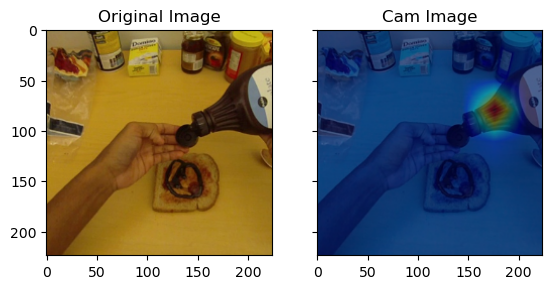

<Figure size 640x480 with 0 Axes>

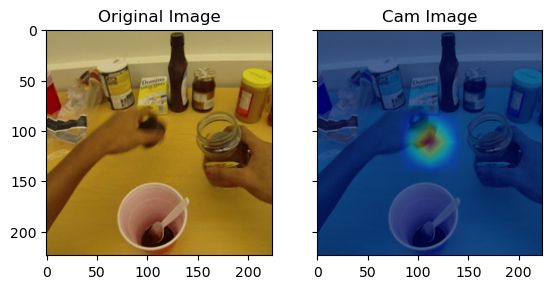

<Figure size 640x480 with 0 Axes>

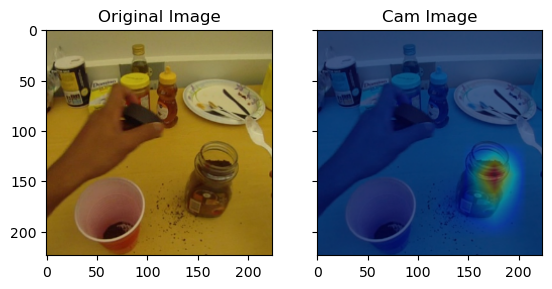

<Figure size 640x480 with 0 Axes>

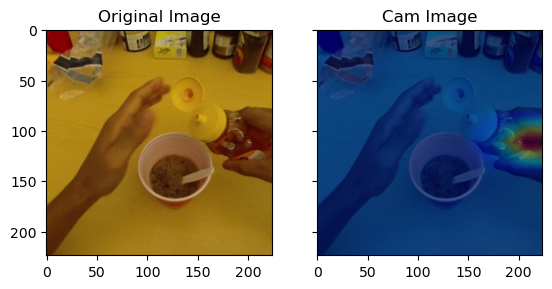

<Figure size 640x480 with 0 Axes>

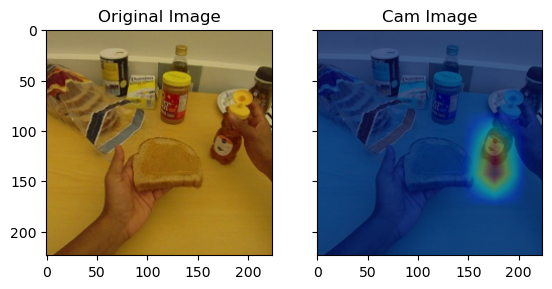

<Figure size 640x480 with 0 Axes>

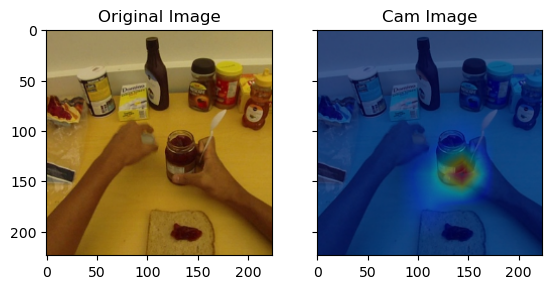

<Figure size 640x480 with 0 Axes>

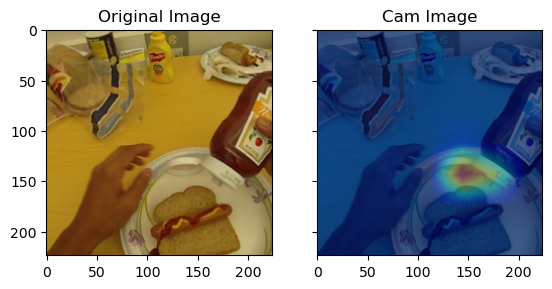

<Figure size 640x480 with 0 Axes>

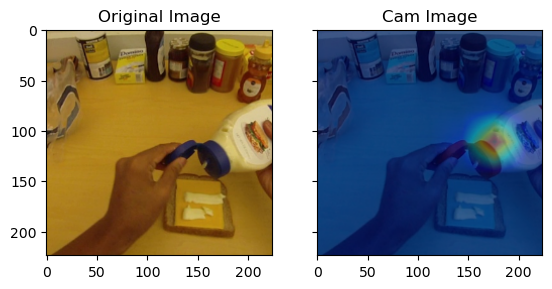

In [16]:
with torch.no_grad():
    for j, (inputs, targets) in enumerate(val_loader):
        inputVariable = inputs.permute(1, 0, 2, 3, 4)
        model.class_activation_map(inputVariable, mean, std)